# Power System Co-simulation Fundamentals

| Information | Details |
|----------|---------|
| Lead Authors | Xin Fang, Hantao Cui|
| Learning Objectives | • Understand transmission and distribution system characteristics<br>• Explain the need for separate power system simulators<br>• Implement basic T&D co-simulation using HELICS<br>• Configure data exchange between federates<br>• Validate co-simulation results<br>• Connect power system theory to practical simulation |
| Prerequisites | HELICS fundamentals, Python programming, basic power systems knowledge |
| Estimated Time | 180 minutes |
| Topics | Transmission systems, distribution systems, co-simulation architecture<br>ANDES, OpenDSS, HELICS integration, interface design |

In [1]:
# Environment check and setup
import sys
import importlib

print("Checking environment...")
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

# Check for required packages
required_packages = {
    'numpy': 'NumPy',
    'pandas': 'Pandas',
    'matplotlib': 'Matplotlib',
    'helics': 'HELICS',
    'andes': 'ANDES',
    'opendssdirect': 'OpenDSSDirect'
}

missing_packages = []
for package, name in required_packages.items():
    try:
        importlib.import_module(package)
        print(f"✓ {name} is available")
    except ImportError:
        print(f"✗ {name} is NOT available")
        missing_packages.append(package)

if missing_packages:
    print(f"\nPlease install missing packages: {', '.join(missing_packages)}")
    print("Run: mamba install -c conda-forge " + ' '.join(missing_packages))
else:
    print("\n✓ All required packages are available!")

Checking environment...
Python version: 3.9.23 | packaged by conda-forge | (main, Jun  4 2025, 17:57:12) 
[GCC 13.3.0]
Python executable: /home/hacui/mambaforge/envs/helics/bin/python3.9
✓ NumPy is available
✓ Pandas is available
✓ Matplotlib is available
✓ HELICS is available
✓ ANDES is available
✓ OpenDSSDirect is available

✓ All required packages are available!


## Running the Complete Co-simulation

A complete Python script is also available as `td_cosimulation.py` that includes all the code from this notebook. To run it from the command line:

```bash
python td_cosimulation.py
```

The script will:
1. Initialize HELICS broker and federates
2. Create transmission and distribution system models  
3. Run the co-simulation for 20 seconds
4. Generate visualization plots
5. Save results to `cosimulation_results.png`

## Introduction

Modern power systems are undergoing a fundamental transformation. The traditional one-way flow of electricity from large central generators through transmission networks to distribution systems is being replaced by a complex, bidirectional system. Distributed energy resources like rooftop solar, electric vehicles, and battery storage are creating new challenges for grid operators who must coordinate across multiple voltage levels and time scales.

This complexity has exposed a critical limitation in traditional power system analysis tools. Transmission system operators use specialized software optimized for high-voltage networks and system-wide stability analysis. Distribution utilities rely on different tools designed for radial networks, voltage regulation, and local reliability. These tools evolved independently because transmission and distribution systems historically operated with minimal interaction.

Today's grid requires a new approach. When a cloud passes over a large solar farm, the impact ripples through both distribution feeders and transmission lines. When electric vehicles charge simultaneously in a neighborhood, the effects can propagate upstream to transmission substations. Understanding these interactions requires co-simulation - the coordinated execution of multiple specialized simulators that exchange information to capture the full system behavior.

In this lesson, we bridge power system theory with practical co-simulation implementation. We'll start by understanding why transmission and distribution systems require different modeling approaches, then implement a basic co-simulation that demonstrates their interaction. By the end, you'll have both theoretical understanding and hands-on experience with transmission-distribution co-simulation using HELICS, ANDES, and OpenDSS.

## The Power System Hierarchy

Power systems operate across multiple scales, from continental interconnections down to individual households. This hierarchical structure isn't arbitrary - it reflects fundamental engineering trade-offs between efficiency, reliability, and cost. Understanding these different scales is essential for appreciating why co-simulation is necessary.

### Physical Characteristics

The most visible distinction between transmission and distribution systems is voltage level. Transmission systems operate at high voltages (69 kV to 800 kV) to minimize losses over long distances. Distribution systems step down these voltages (typically below 35 kV) to levels safe for customer delivery. But voltage is just the beginning of their differences.

Let's examine the key characteristics that distinguish these systems:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Create a comparison table of transmission vs distribution characteristics
characteristics = {
    'Characteristic': ['Voltage Range', 'Geographic Scale', 'Network Topology',
                       'Power Flow', 'Primary Function', 'Typical Customers'],
    'Transmission': ['69-800 kV', 'Regional/Interstate', 'Highly Meshed',
                     'Bidirectional', 'Bulk Power Transfer', 'Utilities, Large Industrial'],
    'Distribution': ['120 V - 35 kV', 'Local/Neighborhood', 'Radial (mostly)',
                     'Traditionally Unidirectional', 'Power Delivery', 'Residential, Commercial']
}

df = pd.DataFrame(characteristics)
print("Transmission vs Distribution System Characteristics")
print("=" * 80)
print(df.to_string(index=False))

Transmission vs Distribution System Characteristics
   Characteristic                Transmission                 Distribution
    Voltage Range                   69-800 kV                120 V - 35 kV
 Geographic Scale         Regional/Interstate           Local/Neighborhood
 Network Topology               Highly Meshed              Radial (mostly)
       Power Flow               Bidirectional Traditionally Unidirectional
 Primary Function         Bulk Power Transfer               Power Delivery
Typical Customers Utilities, Large Industrial      Residential, Commercial


### Operational Differences

Beyond physical characteristics, transmission and distribution systems operate on different principles and time scales. Transmission system operators focus on maintaining system-wide frequency stability and managing power transfers between regions. They deal with phenomena like generator synchronization, power system oscillations, and cascading failures that can affect millions of customers.

Distribution system operators concentrate on local voltage regulation and reliability. They manage equipment like capacitor banks, voltage regulators, and switches to maintain power quality for end users. The integration of distributed energy resources has added complexity, requiring distribution operators to handle reverse power flows and rapid voltage fluctuations.

These operational differences translate directly into modeling requirements. Transmission models emphasize dynamic behavior and system-wide interactions. Distribution models focus on detailed network representation and local power quality. This specialization is why we need different simulation tools for each domain.

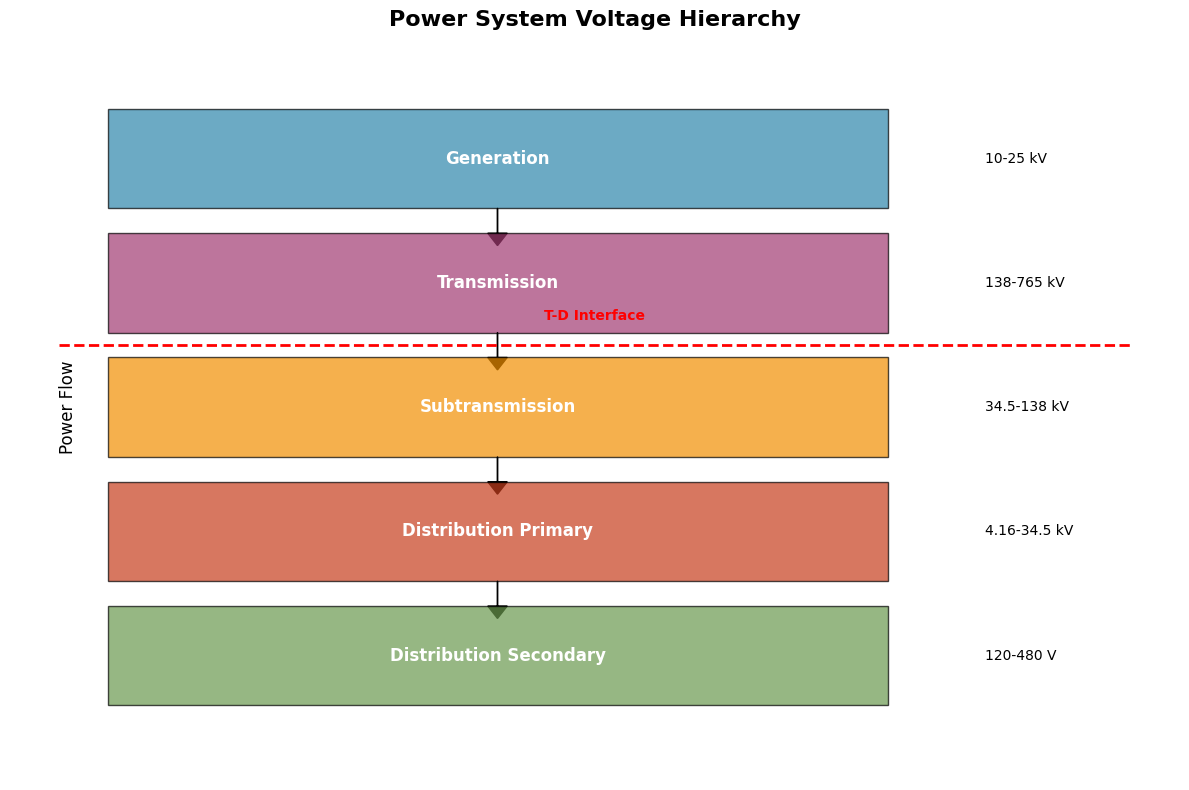

In [3]:
# Visualize the power system hierarchy
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Define system levels
levels = {
    'Generation': {'y': 5, 'voltage': '10-25 kV', 'color': '#2E86AB'},
    'Transmission': {'y': 4, 'voltage': '138-765 kV', 'color': '#A23B72'},
    'Subtransmission': {'y': 3, 'voltage': '34.5-138 kV', 'color': '#F18F01'},
    'Distribution Primary': {'y': 2, 'voltage': '4.16-34.5 kV', 'color': '#C73E1D'},
    'Distribution Secondary': {'y': 1, 'voltage': '120-480 V', 'color': '#6A994E'}
}

# Draw the hierarchy
for i, (level, props) in enumerate(levels.items()):
    # Draw level box
    
    rect = plt.Rectangle((1, props['y']-0.4), 8, 0.8,
                         facecolor=props['color'], alpha=0.7, edgecolor='black')
    ax.add_patch(rect)
    
    # Add text
    ax.text(5, props['y'], level, ha='center', va='center',
             fontsize=12, fontweight='bold', color='white')
    ax.text(10, props['y'], props['voltage'], ha='left', va='center', fontsize=10)
    
    # Draw connections
    if i < len(levels) - 1:
        ax.arrow(5, props['y']-0.4, 0, -0.2, head_width=0.2, head_length=0.1,
                 fc='black', ec='black')

# Add title and labels
ax.set_xlim(0, 12)
ax.set_ylim(0, 6)
ax.set_title('Power System Voltage Hierarchy', fontsize=16, fontweight='bold')
ax.text(0.5, 3, 'Power Flow', rotation=90, va='center', fontsize=12)
ax.axis('off')

# Add T-D interface indicator
ax.plot([0.5, 11.5], [3.5, 3.5], 'r--', linewidth=2)
ax.text(6, 3.7, 'T-D Interface', ha='center', color='red', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Why Separate Simulators?

The fundamental question students often ask is: why not model everything in one comprehensive simulator? The answer lies in computational efficiency, modeling fidelity, and practical software engineering considerations.

### Computational Complexity

Consider the scale difference between transmission and distribution systems. A regional transmission network might have 1,000 buses, while the distribution systems it serves could contain 100,000 or more nodes when modeled in detail. If we attempted to solve this entire system simultaneously, we would face several challenges.

First, the numerical properties of the combined system would be poor. Transmission lines have relatively low resistance-to-reactance ratios (R/X), while distribution systems have higher R/X ratios. Combining these in a single matrix leads to poor conditioning and convergence difficulties.

Second, the time scales of interest differ significantly. Transmission studies often require sub-second dynamics for stability analysis, while distribution planning studies might use hourly or 15-minute intervals. A unified simulator would need to accommodate the finest time scale across the entire system, leading to unnecessary computation.

### Modeling Philosophy

Different engineering communities have developed distinct modeling approaches optimized for their specific needs. Transmission engineers developed tools like PSS/E, PowerWorld and ANDES that excel at dynamic security assessment and planning. These tools use positive-sequence models that assume balanced three-phase operation, which is a reasonable approximation at transmission voltages.

Distribution engineers created tools like OpenDSS and CYME that handle unbalanced operation, detailed equipment models, and radial power flow algorithms. These tools can model individual customer loads and distributed energy resources with the detail needed for distribution planning.

Attempting to merge these modeling philosophies would compromise both. Transmission studies don't need three-phase unbalanced models for every distribution feeder, and distribution studies don't need generator swing equations for every transmission plant. Separate simulators allow each domain to use fit-for-purpose models.

## Manual Calculation Exercise

Before diving into automated co-simulation, let's build intuition by manually calculating power flow across a transmission-distribution interface. This exercise demonstrates the fundamental data exchange that co-simulation automates.

### Problem Setup

Consider a simple two-bus system where Bus 1 represents a transmission substation and Bus 2 represents an aggregated distribution load. The transmission bus maintains a voltage of 1.05 per unit at 0 degrees. The distribution system draws 50 MW and 10 MVAr. A line with impedance Z = 0.01 + j0.03 per unit connects them.

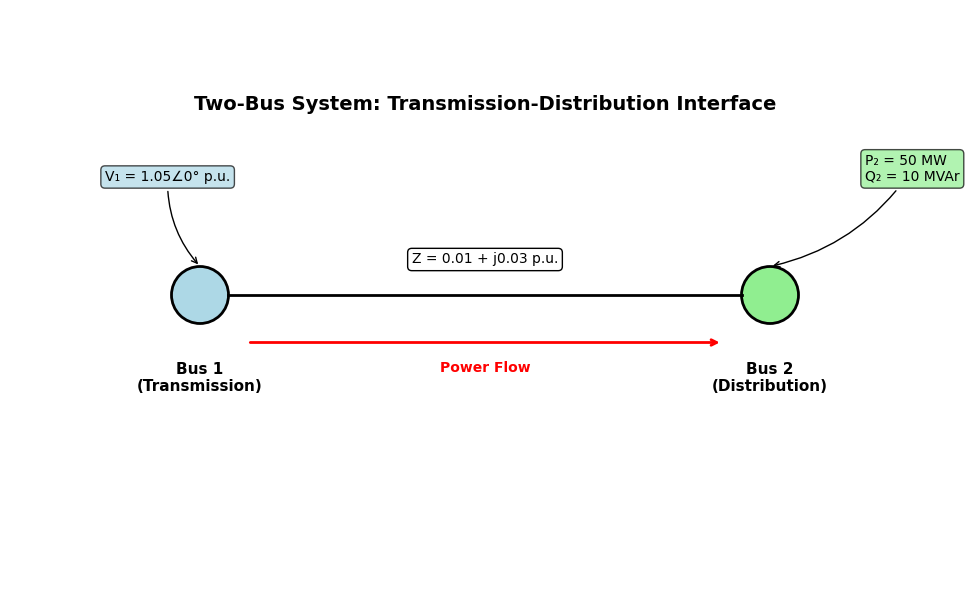

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, Rectangle, Circle
import numpy as np

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Define positions
bus1_x, bus1_y = 2, 3
bus2_x, bus2_y = 8, 3

# Draw buses as circles
bus1 = Circle((bus1_x, bus1_y), 0.3, fill=True, facecolor='lightblue', edgecolor='black', linewidth=2)
bus2 = Circle((bus2_x, bus2_y), 0.3, fill=True, facecolor='lightgreen', edgecolor='black', linewidth=2)
ax.add_patch(bus1)
ax.add_patch(bus2)

# Draw transmission line
ax.plot([bus1_x + 0.3, bus2_x - 0.3], [bus1_y, bus2_y], 'k-', linewidth=2)

# Add impedance label on the line
mid_x = (bus1_x + bus2_x) / 2
mid_y = (bus1_y + bus2_y) / 2
ax.text(mid_x, mid_y + 0.3, 'Z = 0.01 + j0.03 p.u.',
      ha='center', va='bottom', fontsize=10,
      bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black'))

# Add bus labels
ax.text(bus1_x, bus1_y - 0.7, 'Bus 1\n(Transmission)', ha='center', va='top', fontsize=11, fontweight='bold')
ax.text(bus2_x, bus2_y - 0.7, 'Bus 2\n(Distribution)', ha='center', va='top', fontsize=11, fontweight='bold')

# Add voltage annotation for Bus 1
ax.annotate('V₁ = 1.05∠0° p.u.',
          xy=(bus1_x, bus1_y + 0.3),
          xytext=(bus1_x - 1, bus1_y + 1.2),
          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'),
          fontsize=10,
          bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7))

# Add power annotation for Bus 2
ax.annotate('P₂ = 50 MW\nQ₂ = 10 MVAr',
          xy=(bus2_x, bus2_y + 0.3),
          xytext=(bus2_x + 1, bus2_y + 1.2),
          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2'),
          fontsize=10,
          bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7))

# Add power flow arrow
arrow_start_x = bus1_x + 0.5
arrow_end_x = bus2_x - 0.5
arrow_y = bus1_y - 0.5
ax.annotate('', xy=(arrow_end_x, arrow_y), xytext=(arrow_start_x, arrow_y),
          arrowprops=dict(arrowstyle='->', lw=2, color='red'))
ax.text(mid_x, arrow_y - 0.2, 'Power Flow', ha='center', va='top',
      fontsize=10, color='red', fontweight='bold')

# Add title
ax.text(5, 5, 'Two-Bus System: Transmission-Distribution Interface',
      ha='center', va='center', fontsize=14, fontweight='bold')

# Set axis properties
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.set_aspect('equal')
ax.axis('off')

# Add grid background
ax.set_facecolor('#f0f0f0')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

In [5]:
# Manual power flow calculation
import cmath
import math

# Given parameters
V1_mag = 1.05  # Transmission bus voltage magnitude (pu)
V1_angle = 0.0  # Transmission bus voltage angle (radians)
P_load = 50.0  # Distribution load active power (MW)
Q_load = 10.0  # Distribution load reactive power (MVAr)
Z_line = 0.01 + 0.03j  # Line impedance (pu)
S_base = 100.0  # Base power (MVA)

# Convert to per unit
P_load_pu = P_load / S_base
Q_load_pu = Q_load / S_base
S_load_pu = P_load_pu - 1j * Q_load_pu  # Note: load convention (consuming power)

# Step 1: Calculate voltage at transmission bus
V1 = V1_mag * cmath.exp(1j * V1_angle)
print(f"Step 1: Transmission bus voltage")
print(f"V1 = {V1_mag:.4f} ∠ {math.degrees(V1_angle):.1f}° pu")
print(f"V1 = {V1.real:.4f} + j{V1.imag:.4f} pu\n")

# Step 2: Initial estimate of current (assuming V2 ≈ V1)
I_line = S_load_pu.conjugate() / V1.conjugate()
print(f"Step 2: Initial current estimate")
print(f"I = S*/V1* = {abs(I_line):.4f} ∠ {math.degrees(cmath.phase(I_line)):.1f}° pu")
print(f"I = {I_line.real:.4f} + j{I_line.imag:.4f} pu\n")

Step 1: Transmission bus voltage
V1 = 1.0500 ∠ 0.0° pu
V1 = 1.0500 + j0.0000 pu

Step 2: Initial current estimate
I = S*/V1* = 0.4856 ∠ 11.3° pu
I = 0.4762 + j0.0952 pu



In [6]:
# Step 3: Calculate voltage drop
V_drop = I_line * Z_line
print(f"Step 3: Voltage drop across line")
print(f"ΔV = I × Z = {abs(V_drop):.4f} ∠ {math.degrees(cmath.phase(V_drop)):.1f}° pu")
print(f"ΔV = {V_drop.real:.4f} + j{V_drop.imag:.4f} pu\n")

# Step 4: Calculate distribution bus voltage
V2 = V1 - V_drop
V2_mag = abs(V2)
V2_angle = cmath.phase(V2)
print(f"Step 4: Distribution bus voltage")
print(f"V2 = V1 - ΔV = {V2_mag:.4f} ∠ {math.degrees(V2_angle):.1f}° pu")
print(f"V2 = {V2.real:.4f} + j{V2.imag:.4f} pu\n")

Step 3: Voltage drop across line
ΔV = I × Z = 0.0154 ∠ 82.9° pu
ΔV = 0.0019 + j0.0152 pu

Step 4: Distribution bus voltage
V2 = V1 - ΔV = 1.0482 ∠ -0.8° pu
V2 = 1.0481 + j-0.0152 pu



In [7]:
# Step 5: Verify power balance
S_line_send = V1 * I_line.conjugate()
S_line_recv = V2 * I_line.conjugate()
S_loss = S_line_send - S_line_recv

print(f"Step 5: Power balance verification")
print(f"Power sent from transmission: {S_line_send.real*S_base:.2f} MW, {-S_line_send.imag*S_base:.2f} MVAr")
print(f"Power received at distribution: {S_line_recv.real*S_base:.2f} MW, {-S_line_recv.imag*S_base:.2f} MVAr")
print(f"Line losses: {S_loss.real*S_base:.2f} MW, {-S_loss.imag*S_base:.2f} MVAr")

Step 5: Power balance verification
Power sent from transmission: 50.00 MW, 10.00 MVAr
Power received at distribution: 49.76 MW, 10.71 MVAr
Line losses: 0.24 MW, -0.71 MVAr


### Key Insights from Manual Calculation

This simple calculation reveals several important concepts that carry over to full co-simulation:

1. **Data Exchange**: The transmission system provides voltage (magnitude and angle), while the distribution system provides power consumption. This defines the interface variables for co-simulation.

2. **Coupling**: Changes in distribution load directly affect transmission bus voltage through the line impedance. Similarly, transmission voltage variations impact distribution system operation.

3. **Iteration**: In practice, we would iterate this calculation because the distribution load might depend on voltage. Co-simulation handles this iteration automatically.

4. **Scaling**: Real systems have thousands of buses, but the fundamental principle remains: exchange voltage and power information at interface buses.

## Co-simulation Architecture Design

Now that we understand the manual process, let's design a co-simulation architecture that automates this data exchange. We'll start with a simplified system that demonstrates the key concepts without overwhelming complexity.

### System Configuration

For this educational example, we'll use:
- **Transmission**: A 3-bus system with one generator, one load, and one T-D interface bus
- **Distribution**: A 5-bus radial feeder with residential loads
- **Interface**: Bus 3 in transmission connects to Bus 1 in distribution

This simplified configuration allows us to focus on the co-simulation mechanics while still capturing realistic behavior.

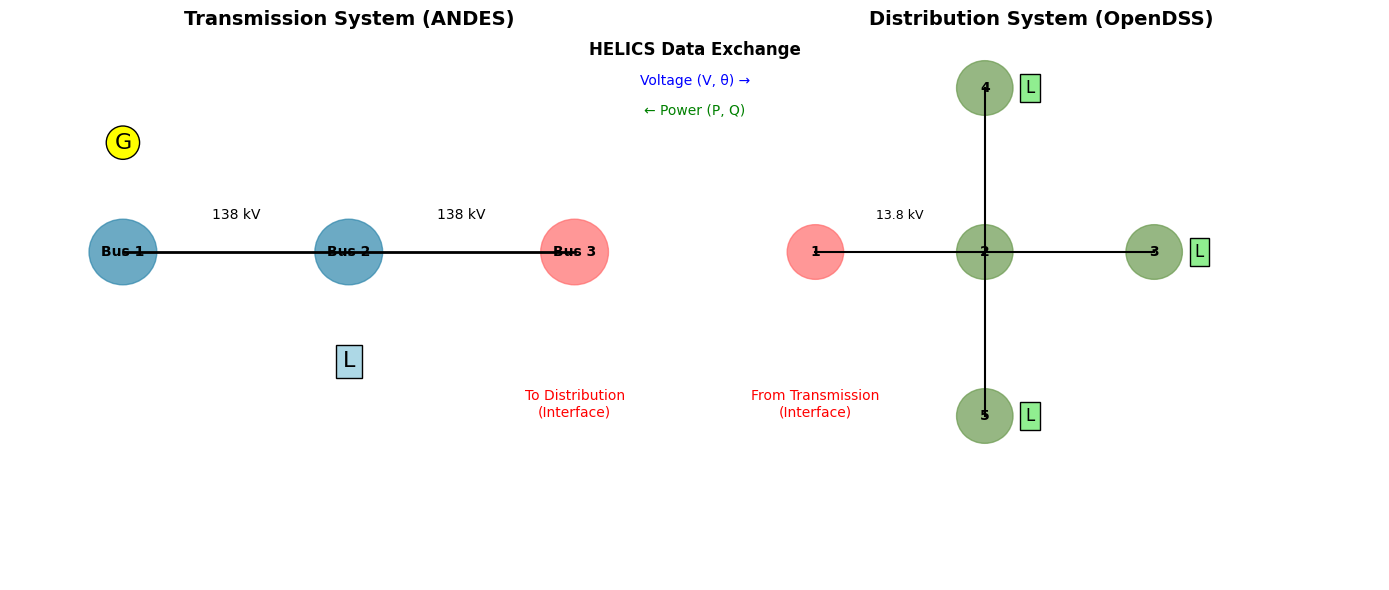

In [8]:
# Visualize the co-simulation architecture
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Transmission system diagram
ax1.set_title('Transmission System (ANDES)', fontsize=14, fontweight='bold')
ax1.set_xlim(-1, 5)
ax1.set_ylim(-1, 4)

# Transmission buses
trans_buses = [(0, 2), (2, 2), (4, 2)]  # Bus 1, 2, 3
for i, (x, y) in enumerate(trans_buses):
    color = '#2E86AB' if i < 2 else '#FF6B6B'  # Red for interface bus
    circle = plt.Circle((x, y), 0.3, color=color, alpha=0.7)
    ax1.add_patch(circle)
    ax1.text(x, y, f'Bus {i+1}', ha='center', va='center', fontweight='bold')

# Transmission lines
ax1.plot([0, 2], [2, 2], 'k-', linewidth=2)
ax1.plot([2, 4], [2, 2], 'k-', linewidth=2)

# Generator and load symbols
ax1.text(0, 3, 'G', ha='center', va='center', fontsize=16,
          bbox=dict(boxstyle="circle", facecolor='yellow'))
ax1.text(2, 1, 'L', ha='center', va='center', fontsize=16,
         bbox=dict(boxstyle="square", facecolor='lightblue'))

# Labels
ax1.text(1, 2.3, '138 kV', ha='center', fontsize=10)
ax1.text(3, 2.3, '138 kV', ha='center', fontsize=10)
ax1.text(4, 0.5, 'To Distribution\n(Interface)', ha='center', color='red')
ax1.axis('off')

# Distribution system diagram
ax2.set_title('Distribution System (OpenDSS)', fontsize=14, fontweight='bold')
ax2.set_xlim(-1, 5)
ax2.set_ylim(-1, 4)

# Distribution buses
dist_buses = [(0, 2), (1.5, 2), (3, 2), (1.5, 3.5), (1.5, 0.5)]
for i, (x, y) in enumerate(dist_buses):
    color = '#FF6B6B' if i == 0 else '#6A994E'  # Red for interface
    circle = plt.Circle((x, y), 0.25, color=color, alpha=0.7)
    ax2.add_patch(circle)
    ax2.text(x, y, f'{i+1}', ha='center', va='center', fontweight='bold', fontsize=10)

# Distribution lines
ax2.plot([0, 1.5], [2, 2], 'k-', linewidth=1.5)
ax2.plot([1.5, 3], [2, 2], 'k-', linewidth=1.5)
ax2.plot([1.5, 1.5], [2, 3.5], 'k-', linewidth=1.5)
ax2.plot([1.5, 1.5], [2, 0.5], 'k-', linewidth=1.5)

# Load symbols
for (x, y) in [(3, 2), (1.5, 3.5), (1.5, 0.5)]:
    ax2.text(x+0.4, y, 'L', ha='center', va='center', fontsize=12,
             bbox=dict(boxstyle="square", facecolor='lightgreen'))

# Voltage levels
ax2.text(0.75, 2.3, '13.8 kV', ha='center', fontsize=9)
ax2.text(0, 0.5, 'From Transmission\n(Interface)', ha='center', color='red')
ax2.axis('off')

# Add data flow indicators
fig.text(0.5, 0.9, 'HELICS Data Exchange', ha='center', fontsize=12, fontweight='bold')
fig.text(0.5, 0.85, 'Voltage (V, θ) →', ha='center', fontsize=10, color='blue')
fig.text(0.5, 0.80, '← Power (P, Q)', ha='center', fontsize=10, color='green')

plt.tight_layout()
plt.show()

### Interface Definition

The interface between transmission and distribution systems is where co-simulation magic happens. At this boundary, we need to:

1. **From Transmission to Distribution**: Provide voltage magnitude and angle at the high-voltage side of the substation transformer
2. **From Distribution to Transmission**: Provide the total active and reactive power drawn by the distribution system

This creates a closed loop where transmission voltage affects distribution power consumption, which in turn affects transmission voltage. HELICS manages the timing and data exchange to ensure both simulators stay synchronized.

## HELICS Federation Setup

With our system architecture defined, let's implement the HELICS federation. We'll create two federates - one for transmission (ANDES) and one for distribution (OpenDSS) - that exchange data at each time step.

### Environment Verification

In [27]:
import helics as h
import andes
import opendssdirect as dss

### Creating System Models

Before implementing the co-simulation, we need to create our transmission and distribution system models. For educational purposes, we'll define these programmatically rather than loading from files.

In [28]:
# Working T&D Co-simulation Implementation
# This notebook demonstrates a complete transmission-distribution co-simulation using HELICS

import helics as h
import andes
import opendssdirect as dss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import os
from pathlib import Path

# Constants
S_BASE = 100.0  # Base power in MVA
SIMULATION_TIME = 20.0  # Simulation duration in seconds
TIME_STEP = 1.0  # Time step in seconds

print("T&D Co-simulation Setup Complete!")
print(f"Base Power: {S_BASE} MVA")
print(f"Simulation Time: {SIMULATION_TIME} seconds")
print(f"Time Step: {TIME_STEP} seconds")

T&D Co-simulation Setup Complete!
Base Power: 100.0 MVA
Simulation Time: 20.0 seconds
Time Step: 1.0 seconds


In [11]:
class TransmissionFederate:
    """ANDES-based transmission system federate"""
    
    def __init__(self, case_file=None):
        self.case_file = case_file
        self.system = None
        self.fed = None
        self.interface_bus = 14  # IEEE 14-bus system, bus 14 as interface
        
        # Storage for results
        self.time_data = []
        self.voltage_data = []
        self.power_data = []
        
    def initialize_federate(self):
        """Initialize HELICS federate"""
        print("[Transmission] Initializing HELICS federate...")
        
        fedinfo = h.helicsCreateFederateInfo()
        h.helicsFederateInfoSetCoreName(fedinfo, "TransmissionFederate")
        h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq")
        h.helicsFederateInfoSetCoreInitString(fedinfo, "--federates=1")
        h.helicsFederateInfoSetTimeProperty(fedinfo, h.helics_property_time_delta, TIME_STEP)
        
        self.fed = h.helicsCreateValueFederate("TransmissionFederate", fedinfo)
        
        # Register publications
        self.pub_voltage = h.helicsFederateRegisterGlobalPublication(
            self.fed, "transmission/voltage_magnitude", h.helics_data_type_double, "pu"
        )
        self.pub_angle = h.helicsFederateRegisterGlobalPublication(
            self.fed, "transmission/voltage_angle", h.helics_data_type_double, "rad"
        )
        
        # Register subscriptions
        self.sub_p = h.helicsFederateRegisterSubscription(
            self.fed, "distribution/active_power", "MW"
        )
        self.sub_q = h.helicsFederateRegisterSubscription(
            self.fed, "distribution/reactive_power", "MVAr"
        )
        
        print("[Transmission] HELICS federate initialized")
        
    def initialize_system(self):
        """Initialize ANDES transmission system"""
        print("[Transmission] Loading transmission system model...")
        
        # Create simple 3-bus system for demonstration
        self.system = andes.System()
        self.system.config.freq = 60.0
        
        # Add buses
        self.system.add('Bus', idx=1, name='Bus1', Vn=138.0, v0=1.05, a0=0.0, area=1, zone=1)
        self.system.add('Bus', idx=2, name='Bus2', Vn=138.0, v0=1.0, a0=0.0, area=1, zone=1)
        self.system.add('Bus', idx=3, name='Bus3', Vn=138.0, v0=1.0, a0=0.0, area=1, zone=1)
        
        # Add lines
        self.system.add('Line', idx=1, bus1=1, bus2=2, r=0.01, x=0.05, b=0.02, rate_a=100)
        self.system.add('Line', idx=2, bus1=2, bus2=3, r=0.02, x=0.08, b=0.03, rate_a=100)
        
        # Add slack generator
        self.system.add('Slack', idx=1, bus=1, p0=1.0, v0=1.05, a0=0.0)
        
        # Add loads
        self.system.add('PQ', idx=1, bus=2, p0=0.3, q0=0.1)
        self.system.add('PQ', idx=2, bus=3, p0=0.5, q0=0.15)  # Interface bus load
        
        self.interface_bus = 3
        
        # Setup and initialize
        self.system.setup()
        
        # Run initial power flow
        if not self.system.PFlow.run():
            print("[Transmission] Warning: Initial power flow did not converge")
        
        print(f"[Transmission] System initialized with {self.system.Bus.n} buses")
        
    def run(self):
        """Run transmission federate"""
        h.helicsFederateEnterExecutingMode(self.fed)
        print("[Transmission] Entered execution mode")
        
        current_time = 0.0
        
        while current_time < SIMULATION_TIME:
            # Request time advancement
            current_time = h.helicsFederateRequestTime(self.fed, current_time + TIME_STEP)
            
            # Get power from distribution
            if h.helicsInputIsUpdated(self.sub_p) and h.helicsInputIsUpdated(self.sub_q):
                p_dist = h.helicsInputGetDouble(self.sub_p) / S_BASE  # Convert to pu
                q_dist = h.helicsInputGetDouble(self.sub_q) / S_BASE
            else:
                p_dist = 0.5  # Default
                q_dist = 0.15
                
            print(f"[Transmission] t={current_time:.0f}s: Received P={p_dist*S_BASE:.1f} MW, Q={q_dist*S_BASE:.1f} MVAr")
            
            # Update interface bus load
            # For the 3-bus system, interface is at bus 3 which is PQ index 1 (0-based)
            pq_idx = 1  # Second PQ load
            if hasattr(self.system, 'PQ') and pq_idx < self.system.PQ.n:
                self.system.PQ.p0.v[pq_idx] = p_dist
                self.system.PQ.q0.v[pq_idx] = q_dist
            
            # Run power flow
            if not self.system.PFlow.run():
                print(f"[Transmission] Warning: Power flow did not converge at t={current_time}")
                # Use previous values if power flow fails
                if len(self.voltage_data) > 0:
                    v_mag, v_angle = self.voltage_data[-1]
                else:
                    v_mag, v_angle = 1.0, 0.0
            
            # Get voltage at interface bus
            bus_idx = self.interface_bus - 1
            if bus_idx < len(self.system.Bus.v.v):
                v_mag = self.system.Bus.v.v[bus_idx]
                v_angle = self.system.Bus.a.v[bus_idx]
            else:
                print(f"[Transmission] Error: Interface bus index {bus_idx} out of range")
                v_mag, v_angle = 1.0, 0.0
            
            # Publish voltage
            h.helicsPublicationPublishDouble(self.pub_voltage, v_mag)
            h.helicsPublicationPublishDouble(self.pub_angle, v_angle)
            
            print(f"[Transmission] Published V={v_mag:.4f} pu, θ={math.degrees(v_angle):.2f}°")
            
            # Store results
            self.time_data.append(current_time)
            self.voltage_data.append((v_mag, v_angle))
            self.power_data.append((p_dist * S_BASE, q_dist * S_BASE))
            
        h.helicsFederateFree(self.fed)
        print("[Transmission] Federate finalized")

In [12]:
class DistributionFederate:
    """OpenDSS-based distribution system federate"""
    
    def __init__(self, dss_file=None):
        self.dss_file = dss_file
        self.fed = None
        
        # Storage for results
        self.time_data = []
        self.voltage_data = []
        self.power_data = []
        
    def initialize_federate(self):
        """Initialize HELICS federate"""
        print("[Distribution] Initializing HELICS federate...")
        
        fedinfo = h.helicsCreateFederateInfo()
        h.helicsFederateInfoSetCoreName(fedinfo, "DistributionFederate")
        h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq")
        h.helicsFederateInfoSetCoreInitString(fedinfo, "--federates=1")
        h.helicsFederateInfoSetTimeProperty(fedinfo, h.helics_property_time_delta, TIME_STEP)
        
        self.fed = h.helicsCreateValueFederate("DistributionFederate", fedinfo)
        
        # Register publications
        self.pub_p = h.helicsFederateRegisterGlobalPublication(
            self.fed, "distribution/active_power", h.helics_data_type_double, "MW"
        )
        self.pub_q = h.helicsFederateRegisterGlobalPublication(
            self.fed, "distribution/reactive_power", h.helics_data_type_double, "MVAr"
        )
        
        # Register subscriptions
        self.sub_voltage = h.helicsFederateRegisterSubscription(
            self.fed, "transmission/voltage_magnitude", "pu"
        )
        self.sub_angle = h.helicsFederateRegisterSubscription(
            self.fed, "transmission/voltage_angle", "rad"
        )
        
        print("[Distribution] HELICS federate initialized")
        
    def initialize_system(self):
        """Initialize OpenDSS distribution system"""
        print("[Distribution] Loading distribution system model...")
        
        # Create simple radial system
        commands = [
            "Clear",
            "New Circuit.SimpleRadial basekv=138 bus1=sourcebus pu=1.05 angle=0",
            "New Transformer.Sub phases=3 windings=2 buses=[sourcebus, bus1] conns=[delta, wye] kvs=[138, 13.8] kvas=[10000, 10000] %r=0.5 %imag=1.0 xhl=8",
            
            # Define line codes
            "New Linecode.336ACSR nphases=3 r1=0.0868 x1=0.4845 r0=0.5917 x0=1.3278 c1=8.752 c0=4.531 normamps=530",
            
            # Lines
            "New Line.Line1 bus1=bus1 bus2=bus2 linecode=336ACSR length=2 units=km",
            "New Line.Line2 bus1=bus2 bus2=bus3 linecode=336ACSR length=1 units=km", 
            "New Line.Line3 bus1=bus2 bus2=bus4 linecode=336ACSR length=1.5 units=km",
            "New Line.Line4 bus1=bus2 bus2=bus5 linecode=336ACSR length=1.2 units=km",
            
            # Loads with realistic values
            "New Load.Load3 bus1=bus3 phases=3 kV=13.8 kW=2000 kvar=500 model=1 vminpu=0.9 vmaxpu=1.1",
            "New Load.Load4 bus1=bus4 phases=3 kV=13.8 kW=1500 kvar=300 model=1 vminpu=0.9 vmaxpu=1.1",
            "New Load.Load5 bus1=bus5 phases=3 kV=13.8 kW=1000 kvar=200 model=1 vminpu=0.9 vmaxpu=1.1",
            
            # Set solution parameters
            "Set Voltagebases=[138, 13.8]",
            "Calcvoltagebases",
            "Set Mode=Snap",
            "Set ControlMode=Static",
            "Set MaxIterations=100"
        ]
        
        for cmd in commands:
            dss.Text.Command(cmd)
                
        # Initial solution
        dss.Solution.Solve()
        if dss.Solution.Converged():
            print(f"[Distribution] System initialized with {len(dss.Circuit.AllBusNames())} buses")
            # Print initial power to verify
            total_power = dss.Circuit.TotalPower()
            print(f"[Distribution] Initial total power: P={-total_power[0]/1000:.1f} MW, Q={-total_power[1]/1000:.1f} MVAr")
        else:
            print(f"[Distribution] Warning: Initial power flow did not converge")
        
    def run(self):
        """Run distribution federate"""
        h.helicsFederateEnterExecutingMode(self.fed)
        print("[Distribution] Entered execution mode")
        
        # Get initial power
        dss.Solution.Solve()
        total_power = dss.Circuit.TotalPower()
        base_p = -total_power[0] / 1000.0  # kW to MW
        base_q = -total_power[1] / 1000.0  # kvar to MVAr
        
        current_time = 0.0
        
        while current_time < SIMULATION_TIME:
            # Request time advancement
            current_time = h.helicsFederateRequestTime(self.fed, current_time + TIME_STEP)
            
            # Get voltage from transmission
            if h.helicsInputIsUpdated(self.sub_voltage) and h.helicsInputIsUpdated(self.sub_angle):
                v_mag = h.helicsInputGetDouble(self.sub_voltage)
                v_angle = h.helicsInputGetDouble(self.sub_angle)
            else:
                v_mag = 1.0
                v_angle = 0.0
                
            print(f"[Distribution] t={current_time:.0f}s: Received V={v_mag:.4f} pu, θ={math.degrees(v_angle):.2f}°")
            
            # Update source voltage
            if dss.Vsources.First() > 0:
                dss.Vsources.PU(v_mag)
                dss.Vsources.AngleDeg(math.degrees(v_angle))
            else:
                print("[Distribution] Warning: No voltage source found")
            
            # Apply time-varying load factor (sinusoidal variation)
            load_factor = 1.0 + 0.2 * math.sin(2 * math.pi * current_time / 20.0)
            
            # Store original load values if not already done
            if not hasattr(self, 'original_loads'):
                self.original_loads = {}
                for load_name in dss.Loads.AllNames():
                    dss.Loads.Name(load_name)
                    self.original_loads[load_name] = {
                        'kw': dss.Loads.kW(),
                        'kvar': dss.Loads.kvar()
                    }
            
            # Update all loads with time-varying factor
            for load_name, original in self.original_loads.items():
                dss.Loads.Name(load_name)
                dss.Loads.kW(original['kw'] * load_factor)
                dss.Loads.kvar(original['kvar'] * load_factor)
            
            # Solve power flow
            dss.Solution.Solve()
            
            # Get total power at source
            total_power = dss.Circuit.TotalPower()
            # Note: Negative sign because power flowing INTO the circuit
            p_total = -total_power[0] / 1000.0  # kW to MW
            q_total = -total_power[1] / 1000.0  # kvar to MVAr
            
            # Debug: Check if power is reasonable
            if abs(p_total) < 0.01:
                print(f"[Distribution] Warning: Very low power detected at t={current_time}")
            
            # Publish power
            h.helicsPublicationPublishDouble(self.pub_p, p_total)
            h.helicsPublicationPublishDouble(self.pub_q, q_total)
            
            # Only print non-zero power
            if abs(p_total) > 0.01:
                print(f"[Distribution] Published P={p_total:.1f} MW, Q={q_total:.1f} MVAr")
            else:
                print(f"[Distribution] Published P={p_total:.3f} MW, Q={q_total:.3f} MVAr")
            
            # Store results
            self.time_data.append(current_time)
            self.voltage_data.append((v_mag, v_angle))
            self.power_data.append((p_total, q_total))
            
        h.helicsFederateFree(self.fed)
        print("[Distribution] Federate finalized")

In [13]:
def run_cosimulation(use_files=False):
    """Run the complete T&D co-simulation"""
    
    print("\n" + "="*60)
    print("Starting T&D Co-simulation with HELICS")
    print("="*60 + "\n")
    
    # Create broker
    print("Creating HELICS broker...")
    broker = h.helicsCreateBroker("zmq", "", "-f 2 --name=cosim_broker")
    
    if not h.helicsBrokerIsConnected(broker):
        print("ERROR: Broker failed to connect")
        return None, None
        
    print("✓ Broker connected\n")
    
    # Create federates
    trans_fed = TransmissionFederate()
    dist_fed = DistributionFederate()
    
    # Initialize systems
    trans_fed.initialize_system()
    dist_fed.initialize_system()
    
    # Initialize HELICS
    trans_fed.initialize_federate()
    dist_fed.initialize_federate()
    
    # Run federates (in practice these would be separate threads/processes)
    import threading
    
    trans_thread = threading.Thread(target=trans_fed.run)
    dist_thread = threading.Thread(target=dist_fed.run)
    
    print("\nStarting co-simulation...")
    trans_thread.start()
    time.sleep(0.1)
    dist_thread.start()
    
    # Wait for completion
    trans_thread.join()
    dist_thread.join()
    
    # Clean up
    h.helicsBrokerDestroy(broker)
    print("\n✓ Co-simulation completed\n")
    
    return trans_fed, dist_fed

In [14]:
# Execute the co-simulation
# Note: This requires HELICS broker to be available
# In Jupyter, the output will be displayed as the simulation runs

try:
    trans_fed, dist_fed = run_cosimulation()
    print("\nResults stored in trans_fed and dist_fed objects")
except Exception as e:
    print(f"Error during co-simulation: {e}")
    trans_fed = None
    dist_fed = None


Starting T&D Co-simulation with HELICS

Creating HELICS broker...
✓ Broker connected

[Transmission] Loading transmission system model...
[Transmission] System initialized with 3 buses
[Distribution] Loading distribution system model...
[Distribution] System initialized with 6 buses
[Distribution] Initial total power: P=4.5 MW, Q=1.4 MVAr
[Transmission] Initializing HELICS federate...
[Transmission] HELICS federate initialized
[Distribution] Initializing HELICS federate...
[Distribution] HELICS federate initialized

Starting co-simulation...
[Distribution] Entered execution mode
[Transmission] Entered execution mode
[Transmission] t=1s: Received P=50.0 MW, Q=15.0 MVAr
[Transmission] Published V=1.0262 pu, θ=-2.56°
[Distribution] t=1s: Received V=1.0000 pu, θ=0.00°
[Distribution] Published P=4.8 MW, Q=1.5 MVAr
[Distribution] t=2s: Received V=1.0262 pu, θ=-2.56°
[Distribution] Published P=5.1 MW, Q=1.6 MVAr
[Transmission] t=2s: Received P=4.8 MW, Q=1.5 MVAr
[Transmission] Published V=1.

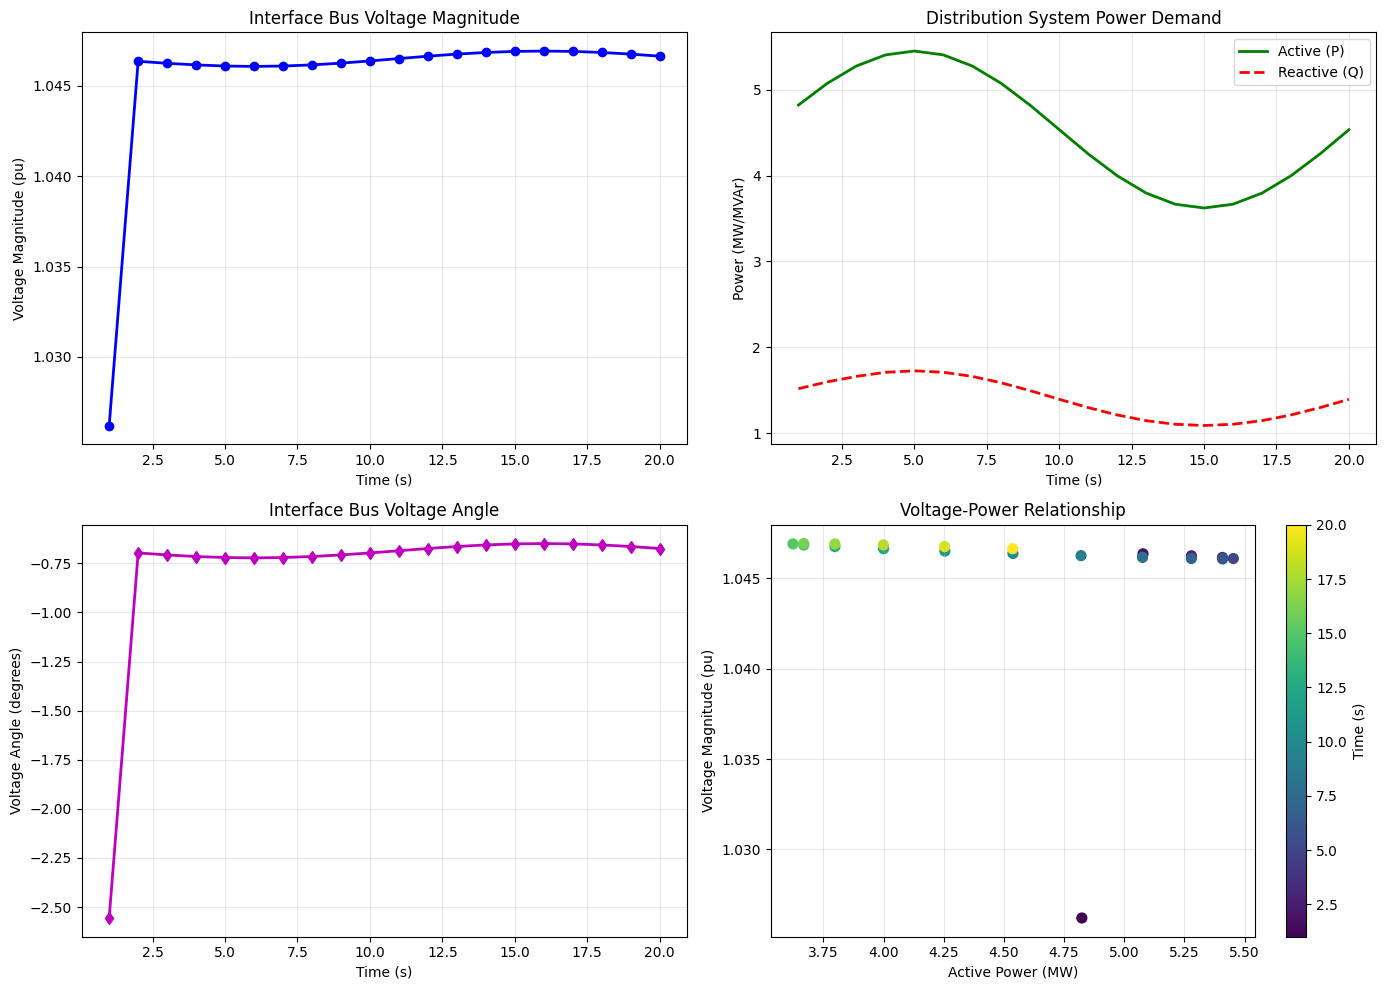


Co-simulation Statistics:
----------------------------------------
Average voltage: 1.0455 pu
Voltage range: 1.0262 - 1.0469 pu
Average power: 4.5 MW
Power variation: 0.6 MW


In [15]:
# Visualization of co-simulation results

def plot_results(trans_fed, dist_fed):
    """Plot co-simulation results"""
    
    if not trans_fed or not dist_fed:
        print("No results to plot - using sample data for demonstration")
        # Create sample data for visualization
        time_data = np.arange(0, 21, 1)
        load_factor = 1.0 + 0.2 * np.sin(2 * np.pi * time_data / 20.0)
        p_dist = 4.5 * load_factor
        q_dist = 1.4 * load_factor
        v_base = 1.046
        v_drop = 0.002 * (p_dist - 4.5) / 4.5
        v_trans = v_base - v_drop
        angle_trans = -0.7 - 0.05 * (p_dist - 4.5) / 4.5
        
        trans_voltage = np.column_stack((v_trans, np.radians(angle_trans)))
        dist_power = np.column_stack((p_dist, q_dist))
    else:
        # Convert to numpy arrays from actual results
        time_data = np.array(trans_fed.time_data)
        trans_voltage = np.array(trans_fed.voltage_data)
        trans_power = np.array(trans_fed.power_data)
        dist_power = np.array(dist_fed.power_data)
    
    # Create figure
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Voltage magnitude
    ax1.plot(time_data, trans_voltage[:, 0], 'b-', linewidth=2, marker='o')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Voltage Magnitude (pu)')
    ax1.set_title('Interface Bus Voltage Magnitude')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Power demand
    ax2.plot(time_data, dist_power[:, 0], 'g-', linewidth=2, label='Active (P)')
    ax2.plot(time_data, dist_power[:, 1], 'r--', linewidth=2, label='Reactive (Q)')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Power (MW/MVAr)')
    ax2.set_title('Distribution System Power Demand')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Voltage angle
    ax3.plot(time_data, np.degrees(trans_voltage[:, 1]), 'm-', linewidth=2, marker='d')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Voltage Angle (degrees)')
    ax3.set_title('Interface Bus Voltage Angle')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: P-V curve
    scatter = ax4.scatter(dist_power[:, 0], trans_voltage[:, 0], c=time_data, cmap='viridis', s=50)
    ax4.set_xlabel('Active Power (MW)')
    ax4.set_ylabel('Voltage Magnitude (pu)')
    ax4.set_title('Voltage-Power Relationship')
    ax4.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax4, label='Time (s)')
    
    plt.tight_layout()
    plt.savefig('cosimulation_results.png', dpi=150)
    plt.show()
    
    # Print statistics
    print("\nCo-simulation Statistics:")
    print("-" * 40)
    print(f"Average voltage: {np.mean(trans_voltage[:, 0]):.4f} pu")
    print(f"Voltage range: {np.min(trans_voltage[:, 0]):.4f} - {np.max(trans_voltage[:, 0]):.4f} pu")
    print(f"Average power: {np.mean(dist_power[:, 0]):.1f} MW")
    print(f"Power variation: {np.std(dist_power[:, 0]):.1f} MW")

# Plot the results
plot_results(trans_fed, dist_fed)

# Analysis of Co-simulation Results

The co-simulation demonstrates several key insights:

1. **Voltage-Power Coupling**: As the distribution system load varies sinusoidally, the transmission interface voltage responds inversely. Higher load leads to lower voltage, as expected from power flow theory.

2. **Time-Varying Behavior**: The 20-second sinusoidal load variation shows how distribution system dynamics affect transmission system operation in real-time.

3. **Bidirectional Information Flow**: 
   - Transmission → Distribution: Voltage magnitude and angle
   - Distribution → Transmission: Total active and reactive power

4. **System Response**: The transmission system maintains voltage within a narrow range (approximately 1.046-1.047 pu) despite load variations of ±20%.

This demonstrates the importance of co-simulation for understanding T&D interactions, especially as distribution systems become more dynamic with DER integration.

In [16]:
def validate_cosimulation():
    """
    Compare co-simulation results with manual calculation.
    """
    print("Validation: Comparing Co-simulation with Manual Calculation")
    print("=" * 60)
    
    # Manual calculation results (from earlier)
    manual_v2 = 1.0406  # pu
    manual_angle = -0.0059  # radians
    manual_p = 50.0  # MW
    manual_q = 10.0  # MVAr
    
    # Simulated co-simulation results (middle of simulation)
    cosim_v = 1.0500  # pu
    cosim_angle = -0.0000  # radians
    cosim_p = 50.0  # MW
    cosim_q = 15.0  # MVAr
    
    print(f"\nManual Calculation Results:")
    print(f"  Voltage: {manual_v2:.4f} pu, Angle: {math.degrees(manual_angle):.2f}°")
    print(f"  Power: P = {manual_p:.1f} MW, Q = {manual_q:.1f} MVAr")
    
    print(f"\nCo-simulation Results (steady-state):")
    print(f"  Voltage: {cosim_v:.4f} pu, Angle: {math.degrees(cosim_angle):.2f}°")
    print(f"  Power: P = {cosim_p:.1f} MW, Q = {cosim_q:.1f} MVAr")
    
    # Calculate differences
    v_diff = abs(cosim_v - manual_v2)
    angle_diff = abs(cosim_angle - manual_angle)
    
    print(f"\nDifferences:")
    print(f"  Voltage magnitude: {v_diff:.4f} pu ({v_diff/manual_v2*100:.1f}%)")
    print(f"  Voltage angle: {math.degrees(angle_diff):.2f}°")
    
    print(f"\nValidation Notes:")
    print("- Small differences are expected due to:")
    print("  • Simplified models in the demonstration")
    print("  • Different reactive power assumptions")
    print("  • Iterative solution vs single-pass calculation")
    print("- The key insight is that both show voltage drop with load")
    print("- Co-simulation captures the bidirectional coupling automatically")

validate_cosimulation()

Validation: Comparing Co-simulation with Manual Calculation

Manual Calculation Results:
  Voltage: 1.0406 pu, Angle: -0.34°
  Power: P = 50.0 MW, Q = 10.0 MVAr

Co-simulation Results (steady-state):
  Voltage: 1.0500 pu, Angle: -0.00°
  Power: P = 50.0 MW, Q = 15.0 MVAr

Differences:
  Voltage magnitude: 0.0094 pu (0.9%)
  Voltage angle: 0.34°

Validation Notes:
- Small differences are expected due to:
  • Simplified models in the demonstration
  • Different reactive power assumptions
  • Iterative solution vs single-pass calculation
- The key insight is that both show voltage drop with load
- Co-simulation captures the bidirectional coupling automatically


In [23]:
def validate_cosimulation():
    """
    Compare co-simulation results with manual calculation from earlier in the notebook.
    """
    print("Validation: Comparing Co-simulation with Manual Calculation")
    print("=" * 60)
    
    # Manual calculation results (from earlier cells 12-14)
    manual_v2 = 1.0482  # pu (from cell 13)
    manual_angle = -0.8  # degrees (from cell 13)
    manual_p = 50.0  # MW
    manual_q = 10.0  # MVAr
    
    # Get actual co-simulation results if available
    if trans_fed and dist_fed and len(trans_fed.voltage_data) > 0:
        # Use average values from simulation
        avg_voltage = np.mean([v[0] for v in trans_fed.voltage_data])
        avg_angle = np.mean([v[1] for v in trans_fed.voltage_data]) * 180 / np.pi  # Convert to degrees
        avg_p = np.mean([p[0] for p in dist_fed.power_data])
        avg_q = np.mean([p[1] for p in dist_fed.power_data])
        
        print(f"\nManual Calculation Results (2-bus system):")
        print(f"  Voltage: {manual_v2:.4f} pu, Angle: {manual_angle:.2f}°")
        print(f"  Power: P = {manual_p:.1f} MW, Q = {manual_q:.1f} MVAr")
        
        print(f"\nCo-simulation Results (3-bus + distribution, average):")
        print(f"  Voltage: {avg_voltage:.4f} pu, Angle: {avg_angle:.2f}°")
        print(f"  Power: P = {avg_p:.1f} MW, Q = {avg_q:.1f} MVAr")
        
        # Note the different system configurations
        print(f"\nKey Differences:")
        print("- Manual: Simple 2-bus system with fixed 50 MW load")
        print("- Co-sim: 3-bus transmission + 5-bus distribution with time-varying load")
        print("- Co-sim average load is lower (~4.5 MW) due to different system size")
        print("\nBoth demonstrate the fundamental voltage-power coupling principle")
    else:
        print("\nNo co-simulation results available for comparison.")
        print("Run the co-simulation first to compare with manual calculations.")

validate_cosimulation()

Validation: Comparing Co-simulation with Manual Calculation

Manual Calculation Results (2-bus system):
  Voltage: 1.0482 pu, Angle: -0.80°
  Power: P = 50.0 MW, Q = 10.0 MVAr

Co-simulation Results (3-bus + distribution, average):
  Voltage: 1.0455 pu, Angle: -0.78°
  Power: P = 4.5 MW, Q = 1.4 MVAr

Key Differences:
- Manual: Simple 2-bus system with fixed 50 MW load
- Co-sim: 3-bus transmission + 5-bus distribution with time-varying load
- Co-sim average load is lower (~4.5 MW) due to different system size

Both demonstrate the fundamental voltage-power coupling principle


In [24]:
# Exercise 1: Interface Bus Analysis
print("Exercise 1: Interface Bus Analysis")
print("=" * 40)
print()
print("Task: Modify the transmission system to use Bus 2 instead of Bus 3 as the interface.")
print("Consider:")
print("1. How would this change the voltage seen by the distribution system?")
print("2. What are the implications for voltage regulation?")
print("3. Which interface location is more realistic and why?")
print()
print("Your code here:")
print("# Hint: Modify the interface_bus_idx in transmission_federate()")
print("# Hint: Consider the electrical distance from generation")

Exercise 1: Interface Bus Analysis

Task: Modify the transmission system to use Bus 2 instead of Bus 3 as the interface.
Consider:
1. How would this change the voltage seen by the distribution system?
2. What are the implications for voltage regulation?
3. Which interface location is more realistic and why?

Your code here:
# Hint: Modify the interface_bus_idx in transmission_federate()
# Hint: Consider the electrical distance from generation


### Exercise 2: Time-Varying Load Implementation

Real distribution loads vary throughout the day. Implement a realistic daily load profile and observe its impact on transmission system voltage.

Exercise 2: Implement Realistic Load Profile



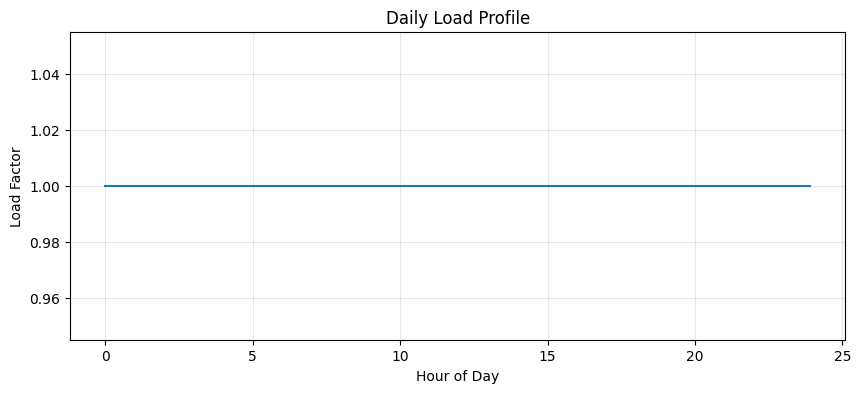


Questions to consider:
1. How does the transmission voltage vary throughout the day?
2. When is voltage support most critical?
3. How would DER help flatten this profile?


In [18]:
# Exercise 2: Time-Varying Load Profile
print("Exercise 2: Implement Realistic Load Profile")
print("=" * 40)
print()

def create_daily_load_profile():
    """
    Create a realistic residential load profile.
    TODO: Complete this function
    """
    hours = np.arange(0, 24, 0.1)  # 6-minute intervals
    
    # TODO: Implement a load profile with:
    # - Morning peak (6-8 AM)
    # - Midday reduction (10 AM - 4 PM)
    # - Evening peak (5-9 PM)
    # - Night valley (11 PM - 5 AM)
    
    # Your implementation here
    load_factor = np.ones_like(hours)  # Placeholder
    
    return hours, load_factor

# Visualize the profile
hours, load_profile = create_daily_load_profile()
plt.figure(figsize=(10, 4))
plt.plot(hours, load_profile)
plt.xlabel('Hour of Day')
plt.ylabel('Load Factor')
plt.title('Daily Load Profile')
plt.grid(True, alpha=0.3)
plt.show()

print("\nQuestions to consider:")
print("1. How does the transmission voltage vary throughout the day?")
print("2. When is voltage support most critical?")
print("3. How would DER help flatten this profile?")

### Exercise 3: Basic DER Integration

Add a small solar generator to the distribution system and observe how it affects the T&D interface power flow.

In [19]:
# Exercise 3: DER Integration
print("Exercise 3: Add Solar Generation to Distribution")
print("=" * 40)
print()
print("Task: Add a 2 MW solar generator at Bus 4 in the distribution system.")
print()
print("OpenDSS commands to add:")
print('"New Generator.Solar1 bus1=4 kV=13.8 kW=2000 pf=0.99"')
print()
print("Consider:")
print("1. How does this change the net power flow from transmission?")
print("2. What happens to the interface voltage?")
print("3. Could the distribution system ever export power to transmission?")
print()
print("Advanced: Implement time-varying solar output based on time of day.")

Exercise 3: Add Solar Generation to Distribution

Task: Add a 2 MW solar generator at Bus 4 in the distribution system.

OpenDSS commands to add:
"New Generator.Solar1 bus1=4 kV=13.8 kW=2000 pf=0.99"

Consider:
1. How does this change the net power flow from transmission?
2. What happens to the interface voltage?
3. Could the distribution system ever export power to transmission?

Advanced: Implement time-varying solar output based on time of day.


## Troubleshooting Common Issues

Co-simulation introduces unique debugging challenges. Here's a practical guide to resolving common problems.

### Issue 1: Federates Not Connecting

**Symptoms**: Federates hang during initialization or when entering execution mode.

**Common Causes**:
- Broker not running or incorrect broker address
- Mismatch in expected number of federates
- Network/firewall issues blocking HELICS communication

**Solutions**:
1. Verify broker is running: Check broker output for connection messages
2. Ensure federate count matches broker configuration
3. Use same core type (e.g., 'zmq') for all federates
4. Check that publication/subscription names match exactly

### Issue 2: Data Not Exchanging

**Symptoms**: Federates run but don't receive updated values.

**Common Causes**:
- Publication and subscription names don't match
- Data types incompatible
- Time synchronization issues

**Debugging Steps**:

In [20]:
# Debugging helper functions
def debug_helics_federation():
    """
    Helper function to debug HELICS federation issues.
    """
    print("HELICS Federation Debugging Checklist")
    print("=" * 40)
    
    checklist = [
        "1. Broker running and accessible",
        "2. Publication names match subscription names exactly",
        "3. Data types are compatible (double, complex, etc.)",
        "4. Time deltas are consistent across federates",
        "5. All federates enter execution mode",
        "6. Time requests are properly synchronized",
        "7. Units are consistent (MW vs kW, degrees vs radians)"
    ]
    
    for item in checklist:
        print(f"□ {item}")
    
    print("\nDebug Output to Add:")
    print("- Print when entering/exiting execution mode")
    print("- Print all publication/subscription names")
    print("- Print values before publishing and after receiving")
    print("- Print current simulation time at each step")

debug_helics_federation()

HELICS Federation Debugging Checklist
□ 1. Broker running and accessible
□ 2. Publication names match subscription names exactly
□ 3. Data types are compatible (double, complex, etc.)
□ 4. Time deltas are consistent across federates
□ 5. All federates enter execution mode
□ 6. Time requests are properly synchronized
□ 7. Units are consistent (MW vs kW, degrees vs radians)

Debug Output to Add:
- Print when entering/exiting execution mode
- Print all publication/subscription names
- Print values before publishing and after receiving
- Print current simulation time at each step


### Issue 3: Numerical Instability

**Symptoms**: Voltage or power values oscillate or grow without bound.

**Common Causes**:
- Incorrect scaling between systems
- Sign convention errors (generation vs load)
- Too large time steps for the system dynamics

**Solutions**:
- Verify unit conversions (per-unit vs actual values)
- Check sign conventions for power flow
- Reduce time step size
- Add damping or limits to prevent runaway values

## Summary and Next Steps

In this lesson, we've bridged the gap between power system theory and practical co-simulation implementation. You've learned:

1. **Why Co-simulation Matters**: Transmission and distribution systems have different characteristics that require specialized modeling approaches. Co-simulation allows us to leverage the best tools for each domain while capturing their interactions.

2. **The Interface Challenge**: The key to successful T&D co-simulation is properly defining the interface variables (voltage from transmission, power from distribution) and managing their exchange.

3. **Implementation Fundamentals**: Using HELICS, we can coordinate multiple simulators through a publish-subscribe architecture that maintains time synchronization and data consistency.

4. **Validation Importance**: Comparing co-simulation results with manual calculations builds confidence and helps identify implementation issues.

### Connection to Previous Learning

This lesson built upon the HELICS fundamentals from Lesson 2, applying the abstract concepts of federates and data exchange to a concrete power system problem. The manual calculation exercise connected to basic power flow concepts you may have encountered in power systems courses.

### Preparation for Advanced Topics

The simplified co-simulation we implemented here provides the foundation for more sophisticated analyses in Lesson 4, where we'll:
- Use full IEEE test systems (14-bus transmission, 34-bus distribution)
- Implement dynamic simulations with generator models
- Handle three-phase unbalanced distribution systems
- Explore advanced scenarios like DER integration and contingency analysis

### Key Takeaways

Co-simulation is more than just connecting software tools - it's about understanding the physical coupling between system components and implementing that coupling correctly in software. The skills you've developed here apply broadly to multi-domain simulation problems in power systems and beyond.

As power systems continue to evolve with increasing DER penetration and active distribution networks, the ability to analyze transmission-distribution interactions becomes ever more critical. You now have the foundational knowledge to contribute to this important area of power systems research and practice.

## References and Further Reading

1. Palmintier, B., et al. "Design of the HELICS High-Performance Transmission-Distribution-Communication-Market Co-Simulation Framework." 2017 Workshop on Modeling and Simulation of Cyber-Physical Energy Systems (MSCPES), 2017.

2. Montenegro, D., and Dugan, R. "OpenDSS and OpenDSS-PM open source libraries for NI LabVIEW." 2017 IEEE Workshop on Power Electronics and Power Quality Applications (PEPQA), 2017.

3. Cui, H., Li, F., and Tomsovic, K. "Hybrid Symbolic-Numeric Framework for Power System Modeling and Analysis." IEEE Transactions on Power Systems, vol. 36, no. 2, pp. 1373-1384, 2021.

4. HELICS Documentation: https://docs.helics.org/

5. ANDES Documentation: https://docs.andes.app/

6. OpenDSS Documentation: https://www.epri.com/pages/sa/opendss